In [1]:
# Model Prediction Pipeline - Using Three Trained Models



In [2]:
import pandas as pd
import numpy as np
import joblib
import os
import pickle
import matplotlib.pyplot as plt
import logging
import seaborn as sns
from datetime import datetime
from typing import Dict, List, Optional, Union, Any
import warnings
warnings.filterwarnings('ignore')

In [3]:


# Try to import PyCaret for model loading
try:
    from pycaret.regression import load_model as pycaret_load_model, predict_model
    PYCARET_AVAILABLE = True
    logging.info("PyCaret is available for model loading")
except ImportError:
    PYCARET_AVAILABLE = False
    logging.warning("PyCaret not available, falling back to pickle loading")

# Configure logging with timestamps
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [4]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Define paths (adjust these to match your folder structure)
MODELS_DIR= "../models"
DATA_FOLDER = "../data"
LOGS_FOLDER = "../logs"
SCALER_FILE = 'standard_scaler'
FEATURE_COLS_FILE = 'pycaret_processed_features_before_model_training.csv'



In [5]:
# Sets up an automatic timestamp printout after each Jupyter cell execution 
# and configures the default visualization style.
from IPython import get_ipython

def setup_timestamp_callback():
    """Setup a timestamp callback for Jupyter cells without clearing existing callbacks."""
    ip = get_ipython()
    if ip is not None:
        # Define timestamp function
        def print_timestamp(*args, **kwargs):
            """Print timestamp after cell execution."""
            print(f"Cell executed at: {datetime.now()}")
        
        # Check if our callback is already registered
        callbacks = ip.events.callbacks.get('post_run_cell', [])
        for cb in callbacks:
            if hasattr(cb, '__name__') and cb.__name__ == 'print_timestamp':
                # Already registered
                return
                
        # Register new callback if not already present
        ip.events.register('post_run_cell', print_timestamp)
        print("Timestamp printing activated.")
    else:
        print("Not running in IPython/Jupyter environment.")

# Setup timestamp callback
setup_timestamp_callback()

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Timestamp printing activated.
Cell executed at: 2025-07-08 11:43:11.921234


In [6]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def ensure_directories():
    """Ensure all required directories exist."""
    for directory in [MODELS_DIR, DATA_FOLDER, LOGS_FOLDER]:
        if not os.path.exists(directory):
            os.makedirs(directory)
            logging.info(f"Created directory: {directory}")

def list_available_models() -> List[str]:
    """
    List all available models in the models directory.
    
    Returns:
        List[str]: Names of available trained models (without extension)
    """
    ensure_directories()
    
    # Get all .pkl files except scaler.pkl
    model_files = []
    for f in os.listdir(MODELS_DIR):
        if f.endswith('.pkl') and not (SCALER_FILE in f.lower()):
            model_name = os.path.splitext(f)[0]
            model_files.append(model_name)
    
    logging.info(f"Found {len(model_files)} available models: {model_files}")
    return model_files

def check_required_models() -> Dict[str, bool]:
    """
    Check for existing models in the models directory.
    
    Returns:
        Dict[str, bool]: Dictionary with model status (True if found)
    """
    ensure_directories()
    
    # Get all model files
    existing_files = os.listdir(MODELS_DIR)
    existing_models = [f for f in existing_files if f.endswith('.pkl')]
    
    # Check for at least one model and optionally a scaler
    has_models = any(f for f in existing_models if not f.startswith(SCALER_FILE))
    has_scaler = any(f for f in existing_models if f.startswith(SCALER_FILE))
    
    model_status = {
        "models_available": has_models,
        "scaler_available": has_scaler,
        "found_models": [os.path.splitext(f)[0] for f in existing_models if not (SCALER_FILE in f.lower())]
    }
    
    if has_models:
        logging.info(f"Found models in '{MODELS_DIR}': {[f for f in existing_models if not (SCALER_FILE in f.lower())]}")
    else:
        logging.warning(f"No trained models found in '{MODELS_DIR}'")
        logging.info("Please train and save models via PyCaret in your Jupyter notebook before using this app.")
    
    return model_status

def load_single_model(model_name: str) -> Optional[Any]:
    """
    Load a model from the models directory, supporting both PyCaret and pickle formats.
    
    Args:
        model_name (str): Name of the model to load (without extension)
        
    Returns:
        Optional[Any]: Loaded model object or None if not found/error
    """
    model_path = os.path.join(MODELS_DIR, model_name)
    model_path_with_ext = os.path.join(MODELS_DIR, f'{model_name}.pkl')
    
    # First, try PyCaret's load_model (without extension)
    if PYCARET_AVAILABLE:
        try:
            model = pycaret_load_model(model_path)
            logging.info(f"Successfully loaded PyCaret model: {model_name}")
            logging.info(f"Model type: {type(model)}")
            return model
        except Exception as e:
            logging.warning(f"PyCaret load failed for '{model_name}': {str(e)}")
    
    # Fall back to pickle loading (with extension)
    if os.path.exists(model_path_with_ext):
        try:
            with open(model_path_with_ext, 'rb') as f:
                model = pickle.load(f)
            
            logging.info(f"Successfully loaded pickle model: {model_name}")
            logging.info(f"Loaded object type: {type(model)}")
            
            # For PyCaret models saved with pickle, they might be wrapped
            if hasattr(model, 'predict') or hasattr(model, '_predict'):
                return model
            else:
                logging.error(f"Loaded object '{model_name}' does not have prediction capability")
                return None
                
        except Exception as e:
            logging.error(f"Error loading model '{model_name}' with pickle: {str(e)}")
    
    logging.error(f"Model file '{model_name}' not found in either format")
    return None

def load_scaler() -> Optional[Any]:
    """
    Load the scaler if available in the models directory.
    
    Returns:
        Optional[Any]: Loaded scaler object or None if not found/error
    """
    ensure_directories()
    scaler_files = [f for f in os.listdir(MODELS_DIR) 
                   if SCALER_FILE in f.lower() and f.endswith('.pkl')]
    
    if not scaler_files:
        logging.info("No scaler found. Proceeding without scaling.")
        return None
    
    # Use the first scaler found
    scaler_path = os.path.join(MODELS_DIR, scaler_files[0])
    
    try:
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        # Check it's a scaler, not an ndarray:
        if hasattr(scaler, 'transform'):
            logging.info(f"Loaded scaler: {type(scaler)}")
            return scaler
        else:
            logging.error("Scaler file is not a transformer object.")
            return None
    except Exception as e:
        logging.error(f"Error loading scaler: {str(e)}")
        return None

def align_features_to_model(features_df: pd.DataFrame, expected_columns: list) -> pd.DataFrame:
    """
    Ensures the features_df has all columns (in correct order) that the model expects.
    Missing columns are filled with 0.
    """
    for col in expected_columns:
        if col not in features_df.columns:
            features_df[col] = 0
    return features_df[expected_columns]


def get_expected_feature_names_from_model(model=None) -> list:
    """
    Gets the expected feature names from a loaded model or falls back to CSV or hardcoded defaults.
    """
    # 1. Try to extract from model directly (best, ensures proper order)
    if model is not None:
        if hasattr(model, 'feature_names_in_'):
            return list(model.feature_names_in_)
        # Some scikit-learn wrappers/transformers or PyCaret models may expose columns differently
        elif hasattr(model, 'X') and hasattr(model.X, 'columns'):
            return list(model.X.columns)
        # Sometimes PyCaret pipelines have steps that expose feature names
        elif hasattr(model, 'named_steps'):
            for step in model.named_steps.values():
                if hasattr(step, 'feature_names_in_'):
                    return list(step.feature_names_in_)

    # 2. Fall back to CSV file (as in PyCaret export)
    feature_cols_path = os.path.join(DATA_FOLDER, FEATURE_COLS_FILE)
    if os.path.exists(feature_cols_path):
        try:
            # Try reading as a single-column CSV (common PyCaret export)
            cols = pd.read_csv(feature_cols_path, header=None)[0].tolist()
            if isinstance(cols[0], str):  # Confirm it's feature names, not numbers
                return cols
        except Exception:
            try:
                # Try reading CSV as DataFrame with headers
                df = pd.read_csv(feature_cols_path)
                return list(df.columns)
            except Exception:
                pass  # Both CSV reads failed

    # 3. Fallback: Hardcoded minimal list (order should match your model training)
    return [
        'project_prf_year_of_project',
        'project_prf_functional_size', 
        'project_prf_max_team_size',
        'process_pmf_docs',
        'tech_tf_tools_used',
        'people_prf_personnel_changes'
    ]

def prepare_full_feature_dataframe(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure the DataFrame has all features (in correct order) used by the model.
    Missing columns are added with 0. Extra columns are ignored.
    """
    feature_names = get_expected_feature_names_from_csv()  # Should return full list of expected features
    # Align columns: keep only needed, add missing with 0, in correct order
    output_df = input_df.reindex(columns=feature_names, fill_value=0)
    return output_df

    
def prepare_features_for_pycaret(features_dict: dict, model=None) -> pd.DataFrame:
    """
    Prepare a prediction DataFrame with the exact columns expected by the model pipeline.
    Missing columns will be filled with 0.

    Args:
        features_dict (dict): Input features as {column_name: value}

    Returns:
        pd.DataFrame: DataFrame with all expected columns, ready for prediction.
    """
    feature_names = get_expected_feature_names_from_model(model)
    # Make sure the input dict has all required keys
    row = {col: features_dict.get(col, 0) for col in feature_names}
    features_df = pd.DataFrame([row])
    # Ensure order and add any missing cols (paranoia)
    features_df = align_features_to_model(features_df, feature_names)
    return features_df

Cell executed at: 2025-07-08 11:43:11.944908


In [7]:
# =============================================================================
# ENHANCED MODEL LOADING AND MANAGEMENT
# =============================================================================

def load_all_models() -> Dict[str, Dict]:
    """
    Load all available models from the models directory.
    
    Returns:
        Dict[str, Dict]: Dictionary with model information and loaded objects
    """
    print("Loading all available models...")
    
    available_models = list_available_models()
    loaded_models = {}
    
    for model_name in available_models:
        try:
            model = load_single_model(model_name)
            if model is not None:
                loaded_models[model_name] = {
                    'model': model,
                    'name': model_name,
                    'type': type(model).__name__
                }
                print(f"✓ Loaded: {model_name}")
            else:
                print(f"✗ Failed to load: {model_name}")
        except Exception as e:
            print(f"✗ Error loading {model_name}: {str(e)}")
    
    # Load scaler if available
    scaler = load_scaler()
    if scaler is not None:
        loaded_models[SCALER_FILE] = {
            'model': scaler,
            'name': SCALER_FILE,
            'type': type(scaler).__name__
        }

    
    print(f"\nSuccessfully loaded {len([k for k in loaded_models.keys() if k != SCALER_FILE])} models")
    return loaded_models

# =============================================================================
# ENHANCED PREDICTION FUNCTIONS
# =============================================================================

def predict_with_single_model(
    features_dict: dict, 
    model_name: str, 
    loaded_models: Dict,
    use_scaler: bool = True
) -> Optional[float]:
    """
    Make a prediction using a specific model with enhanced error handling.
    
    Args:
        features_dict (dict): Input features as dictionary
        model_name (str): Name of the model to use
        loaded_models (Dict): Dictionary of loaded models
        use_scaler (bool): Whether to apply scaling if available
        
    Returns:
        Optional[float]: Predicted value or None if error
    """
    try:
        if model_name not in loaded_models:
            logging.error(f"Model '{model_name}' not loaded")
            return None
        
        model = loaded_models[model_name]['model']
        
        # Prepare features with all expected columns
        features_df = prepare_features_for_pycaret(features_dict, model=model)
        
        # Apply scaler if present and requested
        if use_scaler and 'standard_scaler' in loaded_models:
            scaler = loaded_models['standard_scaler']['model']
            num_cols = features_df.select_dtypes(include=[np.number]).columns
            features_df[num_cols] = scaler.transform(features_df[num_cols])
        
        # PyCaret prediction
        if PYCARET_AVAILABLE:
            try:
                predictions = predict_model(model, data=features_df)
                # Look for typical prediction column
                for col in ['prediction_label', 'Label', 'pred', 'prediction', 'target']:
                    if col in predictions.columns:
                        val = float(predictions[col].iloc[0])
                        return max(0.1, val)
                # Fallback: last column
                return max(0.1, float(predictions.iloc[0, -1]))
            except Exception as e:
                logging.warning(f"PyCaret prediction failed: {str(e)}")
        # Fallback: scikit-learn style
        if hasattr(model, 'predict'):
            try:
                pred = model.predict(features_df)
                val = float(pred.flat[0]) if isinstance(pred, np.ndarray) else float(pred[0])
                return max(0.1, val)
            except Exception as e:
                logging.error(f"Standard prediction failed: {str(e)}")
        return None
    except Exception as e:
        logging.error(f"Prediction error: {str(e)}")
        return None

def make_predictions_all_models(
    features_dict: dict, 
    loaded_models: dict,
    use_scaler: bool = True
) -> dict:
    """
    Make predictions using all loaded models (excluding scaler).
    """
    predictions = {}
    model_names = [name for name in loaded_models.keys() if name != 'standard_scaler']
    print(f"\nMaking predictions with {len(model_names)} models...")
    for model_name in model_names:
        try:
            prediction = predict_with_single_model(
                features_dict, model_name, loaded_models, use_scaler
            )
            if prediction is not None:
                predictions[model_name] = prediction
                print(f"✓ {model_name}: {prediction:.3f}")
            else:
                print(f"✗ {model_name}: Prediction failed")
                predictions[model_name] = None
        except Exception as e:
            print(f"✗ {model_name}: Error - {str(e)}")
            predictions[model_name] = None
    return predictions


Cell executed at: 2025-07-08 11:43:11.960531


In [8]:
# =============================================================================
# EXAMPLE USAGE AND DEMONSTRATIONS
# =============================================================================

def demo_single_prediction():
    """Demonstrate single prediction functionality."""
    print("\n" + "="*50)
    print("DEMO: Single Prediction")
    print("="*50)
    
    # Load models
    loaded_models = load_all_models()
    if not loaded_models:
        print("❌ No models available for demo")
        return
    
    # Sample features
    sample_features = {
        'project_prf_year_of_project': 2023,
        'project_prf_functional_size': 150.5,
        'project_prf_max_team_size': 8,
        'process_pmf_docs': 1,
        'tech_tf_tools_used': 2,
        'people_prf_personnel_changes': 0
    }
    
    # Make predictions with all models
    predictions = make_predictions_all_models(sample_features, loaded_models)
    
    print(f"\nSample Input: {sample_features}")
    print(f"Predictions: {predictions}")
    
    # Plot predictions comparison
    plot_predictions_comparison(predictions)
    
    return predictions

def demo_what_if_analysis():
    """Demonstrate what-if analysis functionality."""
    print("\n" + "="*50)
    print("DEMO: What-If Analysis")
    print("="*50)
    
    # Load models
    loaded_models = load_all_models()
    if not loaded_models:
        print("❌ No models available for demo")
        return
    
    # Base features
    base_features = {
        'project_prf_year_of_project': 2023,
        'project_prf_functional_size': 150.5,
        'project_prf_max_team_size': 8,
        'process_pmf_docs': 1,
        'tech_tf_tools_used': 2,
        'people_prf_personnel_changes': 0
    }
    
    # Vary functional size
    model_name = list(loaded_models.keys())[0]  # Use first available model
    if model_name == SCALER_FILE:
        model_name = list(loaded_models.keys())[1] if len(loaded_models) > 1 else None
    
    if model_name:
        size_values = [50, 100, 150, 200, 250, 300]
        what_if_results = analyze_what_if(
            base_features, model_name, loaded_models,
            'project_prf_functional_size', size_values
        )
        
        print(f"\nWhat-If Analysis Results for 'project_prf_functional_size':")
        for size, pred in zip(what_if_results["param_values"], what_if_results["predictions"]):
            print(f"  Size {size}: Prediction {pred:.3f}")
        
        # Plot what-if analysis
        plot_what_if_analysis(what_if_results, 'project_prf_functional_size')
        
        return what_if_results
    else:
        print("❌ No suitable model found for what-if analysis")
        return None

def demo_feature_importance():
    """Demonstrate feature importance analysis."""
    print("\n" + "="*50)
    print("DEMO: Feature Importance Analysis")
    print("="*50)
    
    # Load models
    loaded_models = load_all_models()
    if not loaded_models:
        print("❌ No models available for demo")
        return
    
    # Analyze feature importance
    importance_results = analyze_feature_importance_all_models(loaded_models)
    
    if importance_results:
        feature_names = get_expected_feature_names_from_csv()
        
        print("\nFeature Importance Summary:")
        for model_name, importance in importance_results.items():
            if len(importance) == len(feature_names):
                print(f"\n{model_name}:")
                for feature, imp in zip(feature_names, importance):
                    print(f"  {feature}: {imp:.4f}")
        
        # Plot feature importance
        plot_feature_importance(importance_results)
        
        return importance_results
    else:
        print("❌ No feature importance available from loaded models")
        return None

def create_interactive_prediction_interface():
    """Create an interactive interface for making predictions."""
    print("\n" + "="*50)
    print("INTERACTIVE PREDICTION INTERFACE")
    print("="*50)
    
    # Load models
    loaded_models = load_all_models()
    if not loaded_models:
        print("❌ No models available")
        return
    
    feature_names = get_expected_feature_names_from_csv()
    
    print("\nEnter values for the following features:")
    print("(Press Enter to use default values)")
    
    # Default values
    default_values = {
        'project_prf_year_of_project': 2023,
        'project_prf_functional_size': 150.0,
        'project_prf_max_team_size': 8,
        'process_pmf_docs': 1,
        'tech_tf_tools_used': 2,
        'people_prf_personnel_changes': 0
    }
    
    features = {}
    
    for feature in feature_names:
        default_val = default_values.get(feature, 0)
        try:
            user_input = input(f"{feature} (default: {default_val}): ").strip()
            if user_input:
                features[feature] = float(user_input)
            else:
                features[feature] = default_val
        except ValueError:
            print(f"Invalid input, using default value: {default_val}")
            features[feature] = default_val
        except KeyboardInterrupt:
            print("\nOperation cancelled by user")
            return
    
    print(f"\nInput Features: {features}")
    
    # Make predictions
    predictions = make_predictions_all_models(features, loaded_models)
    
    print("\nPrediction Results:")
    for model_name, prediction in predictions.items():
        if prediction is not None:
            print(f"  {model_name}: {prediction:.3f}")
        else:
            print(f"  {model_name}: Failed")
    
    # Calculate ensemble
    valid_predictions = [v for v in predictions.values() if v is not None]
    if valid_predictions:
        ensemble_pred = np.mean(valid_predictions)
        ensemble_std = np.std(valid_predictions) if len(valid_predictions) > 1 else 0
        print(f"\nEnsemble Prediction: {ensemble_pred:.3f} ± {ensemble_std:.3f}")
    
    # Plot results
    plot_predictions_comparison(predictions)
    
    return features, predictions

Cell executed at: 2025-07-08 11:43:11.992756


In [9]:
# =============================================================================
# BATCH PROCESSING UTILITIES
# =============================================================================

def process_csv_file(csv_path: str, output_path: str = None):
    """
    Process a CSV file with batch predictions.
    
    Args:
        csv_path (str): Path to input CSV file
        output_path (str): Path to save results (optional)
    """
    print(f"\n📁 Processing CSV file: {csv_path}")
    
    if not os.path.exists(csv_path):
        print(f"❌ File not found: {csv_path}")
        return None
    
    # Load models
    loaded_models = load_all_models()
    if not loaded_models:
        print("❌ No models available")
        return None
    
    # Load data
    try:
        data = pd.read_csv(csv_path)
        print(f"✓ Loaded data: {data.shape}")
    except Exception as e:
        print(f"❌ Error loading CSV: {str(e)}")
        return None
    
    # Process predictions
    results_df = batch_predict_dataframe(data, loaded_models)
    
    # Save results
    if output_path is None:
        output_path = csv_path.replace('.csv', '_predictions.csv')
    
    try:
        results_df.to_csv(output_path, index=False)
        print(f"✓ Results saved to: {output_path}")
    except Exception as e:
        print(f"❌ Error saving results: {str(e)}")
    
    return results_df

def compare_model_performance(results_df: pd.DataFrame):
    """
    Compare performance metrics across models.
    
    Args:
        results_df (pd.DataFrame): DataFrame with predictions from multiple models
    """
    print("\n" + "="*50)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*50)
    
    # Get model columns (exclude original features and ensemble)
    feature_names = get_expected_feature_names_from_csv()
    model_columns = [col for col in results_df.columns 
                    if col not in feature_names 
                    and col not in ['ensemble_prediction', 'prediction_std']]
    
    if not model_columns:
        print("❌ No model predictions found in results")
        return
    
    print("\nPrediction Statistics:")
    print("-" * 50)
    
    for model_col in model_columns:
        if model_col in results_df.columns:
            predictions = results_df[model_col].dropna()
            if len(predictions) > 0:
                print(f"\n{model_col}:")
                print(f"  Count: {len(predictions)}")
                print(f"  Mean:  {predictions.mean():.3f}")
                print(f"  Std:   {predictions.std():.3f}")
                print(f"  Min:   {predictions.min():.3f}")
                print(f"  Max:   {predictions.max():.3f}")
                print(f"  Median: {predictions.median():.3f}")
    
    # Correlation analysis
    try:
        model_data = results_df[model_columns].dropna()
        if len(model_data) > 1 and len(model_columns) > 1:
            print("\nModel Correlation Matrix:")
            print("-" * 30)
            correlation_matrix = model_data.corr()
            print(correlation_matrix.round(3))
            
            # Plot correlation heatmap if matplotlib is available
            try:
                import matplotlib.pyplot as plt
                import seaborn as sns
                
                plt.figure(figsize=(8, 6))
                sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
                plt.title('Model Prediction Correlations')
                plt.tight_layout()
                plt.show()
                
            except ImportError:
                pass
                
    except Exception as e:
        print(f"Error in correlation analysis: {str(e)}")

Cell executed at: 2025-07-08 11:43:12.007200


In [10]:
# =============================================================================
# MAIN EXECUTION AND JUPYTER NOTEBOOK INTERFACE
# =============================================================================

def run_complete_analysis():
    """Run a complete analysis pipeline with all demonstrations."""
    print("🚀 STARTING COMPLETE PREDICTION ANALYSIS")
    print("="*60)
    
    try:
        # 1. Run main pipeline
        print("\n1️⃣ Running Enhanced Prediction Pipeline...")
        results_df, loaded_models, importance_results = run_enhanced_prediction_pipeline()
        
        if results_df is None:
            print("❌ Pipeline failed to complete")
            return
        
        # 2. Demo single prediction
        print("\n2️⃣ Single Prediction Demo...")
        demo_predictions = demo_single_prediction()
        
        # 3. Demo what-if analysis
        print("\n3️⃣ What-If Analysis Demo...")
        what_if_results = demo_what_if_analysis()
        
        # 4. Demo feature importance
        print("\n4️⃣ Feature Importance Demo...")
        feature_importance = demo_feature_importance()
        
        # 5. Model performance comparison
        print("\n5️⃣ Model Performance Comparison...")
        compare_model_performance(results_df)
        
        print("\n✅ COMPLETE ANALYSIS FINISHED SUCCESSFULLY!")
        print("="*60)
        
        return {
            'results_df': results_df,
            'loaded_models': loaded_models,
            'importance_results': importance_results,
            'demo_predictions': demo_predictions,
            'what_if_results': what_if_results,
            'feature_importance': feature_importance
        }
        
    except Exception as e:
        print(f"❌ Error in complete analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# =============================================================================
# JUPYTER NOTEBOOK HELPER FUNCTIONS
# =============================================================================

def setup_notebook_environment():
    """Setup the notebook environment with necessary imports and configurations."""
    print("Setting up notebook environment...")
    
    # Check for required packages
    required_packages = ['pandas', 'numpy', 'scikit-learn']
    optional_packages = ['matplotlib', 'seaborn', 'plotly']
    
    print("\nChecking required packages:")
    for package in required_packages:
        try:
            __import__(package)
            print(f"✓ {package}")
        except ImportError:
            print(f"❌ {package} - REQUIRED")
    
    print("\nChecking optional packages:")
    for package in optional_packages:
        try:
            __import__(package)
            print(f"✓ {package}")
        except ImportError:
            print(f"⚠️ {package} - Optional (for visualization)")
    
    # Setup directories
    ensure_directories()
    
    print("\n📁 Directory structure:")
    for directory in [MODELS_DIR, DATA_FOLDER, LOGS_FOLDER]:
        status = "✓" if os.path.exists(directory) else "❌"
        print(f"{status} {directory}/")
    
    print("\n🎯 Notebook environment setup complete!")

def quick_start_guide():
    """Display a quick start guide for users."""
    print("\n" + "="*60)
    print("🚀 QUICK START GUIDE")
    print("="*60)
    
    print("""
📋 USAGE INSTRUCTIONS:

1. SETUP:
   - Ensure your trained models are saved in the 'models/' directory
   - Models should be saved as .pkl files (PyCaret or pickle format)
   - Feature names should be saved in 'data/pycaret_processed_features_before_model_training.csv'

2. BASIC USAGE:
   # Run complete analysis
   results = run_complete_analysis()
   
   # Single prediction
   predictions = demo_single_prediction()
   
   # Interactive interface
   create_interactive_prediction_interface()

3. BATCH PROCESSING:
   # Process CSV file
   results_df = process_csv_file('your_data.csv')
   
   # Custom data
   results_df, models, importance = run_enhanced_prediction_pipeline(
       data_path='your_data.csv'
   )

4. ANALYSIS:
   # What-if analysis
   what_if_results = demo_what_if_analysis()
   
   # Feature importance
   importance_results = demo_feature_importance()

5. FILES GENERATED:
   - enhanced_predictions.csv (prediction results)
   - feature_importance.csv (feature importance data)
   - Various plots and visualizations

💡 TIP: Start with setup_notebook_environment() to check your setup!
    """)

# =============================================================================
# MAIN EXECUTION BLOCK FOR JUPYTER NOTEBOOKS
# =============================================================================


if __name__ == "__main__":
    # This block runs when the script is executed directly
    print("🎯 Enhanced Model Prediction Pipeline - Jupyter Notebook Ready!")
    print("="*60)
    
    # Setup environment
    setup_notebook_environment()
    
    # Display quick start guide
    quick_start_guide()
    
    # Check for models
    model_status = check_required_models()
    
    if model_status["models_available"]:
        print(f"\n✅ Found {len(model_status['found_models'])} trained models!")
        print("You can now run the analysis pipeline.")
        
        # Uncomment the line below to run complete analysis automatically
        # run_complete_analysis()
        
    else:
        print("\n⚠️ No trained models found.")
        print("Please train and save your models first using PyCaret.")
        print("Then run: run_complete_analysis()")



🎯 Enhanced Model Prediction Pipeline - Jupyter Notebook Ready!
Setting up notebook environment...

Checking required packages:
✓ pandas
✓ numpy
❌ scikit-learn - REQUIRED

Checking optional packages:
✓ matplotlib
✓ seaborn
✓ plotly

📁 Directory structure:
✓ ../models/
✓ ../data/
✓ ../logs/

🎯 Notebook environment setup complete!

🚀 QUICK START GUIDE

📋 USAGE INSTRUCTIONS:

1. SETUP:
   - Ensure your trained models are saved in the 'models/' directory
   - Models should be saved as .pkl files (PyCaret or pickle format)
   - Feature names should be saved in 'data/pycaret_processed_features_before_model_training.csv'

2. BASIC USAGE:
   # Run complete analysis
   results = run_complete_analysis()

   # Single prediction
   predictions = demo_single_prediction()

   # Interactive interface
   create_interactive_prediction_interface()

3. BATCH PROCESSING:
   # Process CSV file
   results_df = process_csv_file('your_data.csv')

   # Custom data
   results_df, models, importance = run_enhance

In [11]:
# =============================================================================
# MAIN EXECUTION PIPELINE
# =============================================================================

def run_enhanced_prediction_pipeline(
    data_path=None, 
    sample_data=None, 
    use_scaler=True,
    save_results=True
):
    """
    Complete enhanced prediction pipeline with all features.
    """
    
    print("STARTING ENHANCED PREDICTION PIPELINE")
    print("="*60)
    
    # Step 1: Check and load models
    model_status = check_required_models()
    if not model_status["models_available"]:
        print("❌ No models found! Please train and save models first.")
        return None, None, None
    
    # Step 2: Load all models
    loaded_models = load_all_models()
    if not loaded_models:
        print("❌ Failed to load any models!")
        return None, None, None
    
    # Step 3: Prepare data
    new_data = prepare_new_data(data_path, sample_data)
    
    # Step 4: Batch predictions
    results_df = batch_predict_dataframe(new_data, loaded_models)
    
    # Step 5: Feature importance analysis
    importance_results = analyze_feature_importance_all_models(loaded_models)
    
    # Step 6: Save results if requested
    if save_results:
        ensure_directories()
        
        # Save predictions
        predictions_path = os.path.join(DATA_FOLDER, 'enhanced_predictions.csv')
        results_df.to_csv(predictions_path, index=False)
        print(f"\n📁 Predictions saved to: {predictions_path}")
        
        # Save feature importance if available
        if importance_results:
            importance_path = os.path.join(DATA_FOLDER, 'feature_importance.csv')
            feature_names = get_expected_feature_names_from_csv()
            
            importance_df_data = {}
            for model_name, importance in importance_results.items():
                if len(importance) == len(feature_names):
                    importance_df_data[model_name] = importance
                else:
                    print(f"⚠️ Feature importance length mismatch for {model_name}")
            
            if importance_df_data:
                importance_df = pd.DataFrame(importance_df_data, index=feature_names)
                importance_df.to_csv(importance_path)
                print(f"📁 Feature importance saved to: {importance_path}")
    
    # Step 7: Summary
    print("\n" + "="*60)
    print("ENHANCED PREDICTION SUMMARY")
    print("="*60)
    
    model_names = [name for name in loaded_models.keys() if name != SCALER_FILE]

Cell executed at: 2025-07-08 11:43:12.039128


In [12]:
# =============================================================================
# ENHANCED BATCH PROCESSING
# =============================================================================

def prepare_new_data(new_data_path=None, sample_data=None):
    """
    Prepare new data for prediction with enhanced flexibility.
    
    Parameters:
    - new_data_path: path to CSV file with new data
    - sample_data: pandas DataFrame with new data
    
    Returns:
    - prepared_data: DataFrame ready for prediction
    """
    
    if new_data_path:
        # Load new data from CSV
        new_data = pd.read_csv(new_data_path)
        print(f"Loaded new data from {new_data_path}: {new_data.shape}")
    elif sample_data is not None:
        new_data = sample_data.copy()
        print(f"Using provided sample data: {new_data.shape}")
    else:
        # Create sample data for demonstration
        print("Creating sample data for demonstration...")
        new_data = pd.DataFrame({
            'project_prf_year_of_project': [2023, 2024, 2022, 2023],
            'project_prf_functional_size': [150.5, 200.0, 89.3, 175.2],
            'project_prf_used_methodology': ['Agile', 'Waterfall', 'Agile', 'Hybrid'],
            'technology_prf_development_platform': ['Web', 'Desktop', 'Mobile', 'Web'],
            'technology_prf_language_type': ['4GL', '3GL', '4GL', '3GL'],
            'project_prf_development_type': ['New', 'Enhancement', 'New', 'Enhancement'],
            'technology_prf_database_used': ['Yes', 'Yes', 'No', 'Yes'],
            'project_prf_max_team_size': [8, 12, 5, 10]
        })
        print(f"Created sample data: {new_data.shape}")
    
    return new_data

def batch_predict_dataframe(data_df: pd.DataFrame, loaded_models: Dict) -> pd.DataFrame:
    """
    Make predictions for a batch of samples in a DataFrame.
    
    Args:
        data_df (pd.DataFrame): DataFrame with samples to predict
        loaded_models (Dict): Dictionary of loaded models
        
    Returns:
        pd.DataFrame: DataFrame with original data and predictions
    """
    print(f"\nProcessing batch predictions for {len(data_df)} samples...")

    # Align columns before iterating
    features_df = prepare_full_feature_dataframe(data_df)
    
    results = []
    model_names = [name for name in loaded_models.keys() if name != SCALER_FILE]

    # Ensure all columns exist and in the correct order for every sample
    feature_names = get_expected_feature_names_from_csv()
    
    for idx, row in features_df.iterrows():
        row_dict = row.to_dict()
        predictions = make_predictions_all_models(row_dict, loaded_models, use_scaler=True)

        # Combine original (unaligned) row + predictions
        orig_row_dict = data_df.iloc[idx].to_dict()
        result_row = orig_row_dict.copy()
        result_row.update(predictions)

        # Ensemble
        valid_preds = [v for v in predictions.values() if v is not None]
        result_row['ensemble_prediction'] = np.mean(valid_preds) if valid_preds else None
        result_row['prediction_std'] = np.std(valid_preds) if len(valid_preds) > 1 else 0

        results.append(result_row)
        
        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(data_df)} samples...")
    
    results_df = pd.DataFrame(results)
    print(f"Batch prediction completed for {len(results_df)} samples")
    
    return results_df



Cell executed at: 2025-07-08 11:43:12.054652


In [13]:
# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_predictions_comparison(predictions_dict: Dict[str, float]):
    """Plot comparison of predictions from different models."""
    try:
        import matplotlib.pyplot as plt
        
        # Filter out None values
        valid_predictions = {k: v for k, v in predictions_dict.items() if v is not None}
        
        if not valid_predictions:
            print("No valid predictions to plot")
            return
        
        models = list(valid_predictions.keys())
        values = list(valid_predictions.values())
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(models, values, color='skyblue', alpha=0.7)
        plt.title('Model Predictions Comparison')
        plt.xlabel('Models')
        plt.ylabel('Predicted Values')
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Matplotlib not available for plotting")
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")

def plot_feature_importance(importance_results: Dict[str, np.ndarray]):
    """Plot feature importance for all models."""
    try:
        import matplotlib.pyplot as plt
        
        if not importance_results:
            print("No feature importance data to plot")
            return
        
        feature_names = get_expected_feature_names_from_csv()
        
        fig, axes = plt.subplots(len(importance_results), 1, 
                               figsize=(12, 4 * len(importance_results)))
        
        if len(importance_results) == 1:
            axes = [axes]
        
        for idx, (model_name, importance) in enumerate(importance_results.items()):
            if len(importance) == len(feature_names):
                axes[idx].bar(feature_names, importance, alpha=0.7)
                axes[idx].set_title(f'Feature Importance - {model_name}')
                axes[idx].set_xlabel('Features')
                axes[idx].set_ylabel('Importance')
                axes[idx].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Matplotlib not available for plotting")
    except Exception as e:
        print(f"Error plotting feature importance: {str(e)}")

def plot_what_if_analysis(what_if_results: Dict[str, List], param_name: str):
    """Plot what-if analysis results."""
    try:
        import matplotlib.pyplot as plt
        
        if not what_if_results["param_values"]:
            print("No what-if analysis data to plot")
            return
        
        plt.figure(figsize=(10, 6))
        plt.plot(what_if_results["param_values"], what_if_results["predictions"], 
                'o-', linewidth=2, markersize=8, color='darkblue')
        plt.title(f'What-If Analysis: Impact of {param_name}')
        plt.xlabel(param_name)
        plt.ylabel('Predicted Value')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Matplotlib not available for plotting")
    except Exception as e:
        print(f"Error plotting what-if analysis: {str(e)}")


Cell executed at: 2025-07-08 11:43:12.069942


In [14]:
def compare_model_and_csv_features(model, csv_path):
    # Get model features
    if hasattr(model, 'feature_names_in_'):
        model_features = list(model.feature_names_in_)
    else:
        model_features = []
    
    # Get CSV features
    try:
        df = pd.read_csv(csv_path)
        csv_features = list(df.columns)
    except:
        csv_features = list(pd.read_csv(csv_path, header=None)[0])
    
    print("Features in CSV file:")
    print(csv_features)
    print(f"\nDoes CSV contain target column? {'project_prf_normalised_work_effort' in csv_features}")

   
    # For PyCaret models, try different ways to get feature names
    if hasattr(model, 'feature_names_in_'):
        features = model.feature_names_in_
    elif hasattr(model, 'feature_names_'):
        features = model.feature_names_
    else:
        # Try to get from the pipeline
        try:
            features = model[:-1].get_feature_names_out()
        except:
            features = "Could not determine features"
    
    print(f"\n{model_name} expected features:")
    print(features)
    print(f"\nDoes MODEL contain target column? {'project_prf_normalised_work_effort' in features}")
    
    # Compare
    model_not_in_csv = [f for f in model_features if f not in csv_features]
    csv_not_in_model = [f for f in csv_features if f not in model_features]
    print("Features in model but NOT in CSV:", model_not_in_csv)
    print("Features in CSV but NOT in model:", csv_not_in_model)
    return model_not_in_csv, csv_not_in_model


Cell executed at: 2025-07-08 11:43:12.085710


<span style="color: red;font-weight: bold; font-size: 40px;">Temporarily fix PyCaret's PyCaret's model serialization issues </span>

In [15]:
# Testing functions first
TARGET_COLUMN = 'project_prf_normalised_work_effort'

# CELL 1: Setup
setup_notebook_environment()
quick_start_guide()

# CELL 2: Load models
loaded_models = load_all_models()
model_names = [name for name in loaded_models.keys() if name != SCALER_FILE]

# CELL 2.5: Compare feature names between models and CSV file; models were trained by PyCaret
csv_feature_file = f"{DATA_FOLDER}/{FEATURE_COLS_FILE}"
for model_name in model_names:
    print(f"\n--- Checking features for model: {model_name} ---")
    model = loaded_models[model_name]['model']
    compare_model_and_csv_features(model, csv_feature_file)

# CELL 3: Define input for prediction
sample_features = {
    'project_prf_year_of_project': 2023,
    'project_prf_functional_size': 150.5,
    'project_prf_max_team_size': 8,
    'process_pmf_docs': 1,
    'tech_tf_tools_used': 2,
    'people_prf_personnel_changes': 0
  }

# CELL 4: Predict
print(f"\nMaking predictions with {len(model_names)} models...")
predictions = {}
for model_name in model_names:
    try:
        prediction = predict_with_single_model(
            sample_features, model_name, loaded_models, use_scaler=True
        )
        if prediction is not None:
            predictions[model_name] = prediction
            print(f"✓ {model_name}: {prediction:.3f}")
        else:
            print(f"✗ {model_name}: Prediction failed")
            predictions[model_name] = None
    except Exception as e:
        print(f"✗ {model_name}: Error - {str(e)}")
        predictions[model_name] = None
print(f"\nSample Input: {sample_features}")
print(f"Predictions: {predictions}")

Setting up notebook environment...

Checking required packages:
✓ pandas
✓ numpy
❌ scikit-learn - REQUIRED

Checking optional packages:
✓ matplotlib
✓ seaborn
✓ plotly

📁 Directory structure:
✓ ../models/
✓ ../data/
✓ ../logs/

🎯 Notebook environment setup complete!

🚀 QUICK START GUIDE

📋 USAGE INSTRUCTIONS:

1. SETUP:
   - Ensure your trained models are saved in the 'models/' directory
   - Models should be saved as .pkl files (PyCaret or pickle format)
   - Feature names should be saved in 'data/pycaret_processed_features_before_model_training.csv'

2. BASIC USAGE:
   # Run complete analysis
   results = run_complete_analysis()

   # Single prediction
   predictions = demo_single_prediction()

   # Interactive interface
   create_interactive_prediction_interface()

3. BATCH PROCESSING:
   # Process CSV file
   results_df = process_csv_file('your_data.csv')

   # Custom data
   results_df, models, importance = run_enhanced_prediction_pipeline(
       data_path='your_data.csv'
   )

4

ERROR:root:Scaler file is not a transformer object.


Transformation Pipeline and Model Successfully Loaded
✓ Loaded: top_model_1_LGBMRegressor
Transformation Pipeline and Model Successfully Loaded
✓ Loaded: top_model_2_GradientBoostingRegressor
Transformation Pipeline and Model Successfully Loaded
✓ Loaded: top_model_3_LassoLars

Successfully loaded 3 models

--- Checking features for model: top_model_1_LGBMRegressor ---
Features in CSV file:
['project_prf_year_of_project', 'project_prf_application_type', 'tech_tf_primary_programming_language', 'project_prf_functional_size', 'project_prf_max_team_size', 'process_pmf_docs', 'tech_tf_tools_used', 'external_eef_organisation_type_banking_insurance_stock', 'external_eef_organisation_type_banking', 'external_eef_organisation_type_communications', 'external_eef_organisation_type_education_institution', 'external_eef_organisation_type_financial_banking_insurance_stock', 'external_eef_organisation_type_financial_property_and_business_services', 'external_eef_organisation_type_government', 'extern

ERROR:root:Scaler file is not a transformer object.
ERROR:root:Scaler file is not a transformer object.


Setting up notebook environment...

Checking required packages:
✓ pandas
✓ numpy
❌ scikit-learn - REQUIRED

Checking optional packages:
✓ matplotlib
✓ seaborn
✓ plotly

📁 Directory structure:
✓ ../models/
✓ ../data/
✓ ../logs/

🎯 Notebook environment setup complete!

🚀 QUICK START GUIDE

📋 USAGE INSTRUCTIONS:

1. SETUP:
   - Ensure your trained models are saved in the 'models/' directory
   - Models should be saved as .pkl files (PyCaret or pickle format)
   - Feature names should be saved in 'data/pycaret_processed_features_before_model_training.csv'

2. BASIC USAGE:
   # Run complete analysis
   results = run_complete_analysis()

   # Single prediction
   predictions = demo_single_prediction()

   # Interactive interface
   create_interactive_prediction_interface()

3. BATCH PROCESSING:
   # Process CSV file
   results_df = process_csv_file('your_data.csv')

   # Custom data
   results_df, models, importance = run_enhanced_prediction_pipeline(
       data_path='your_data.csv'
   )

4

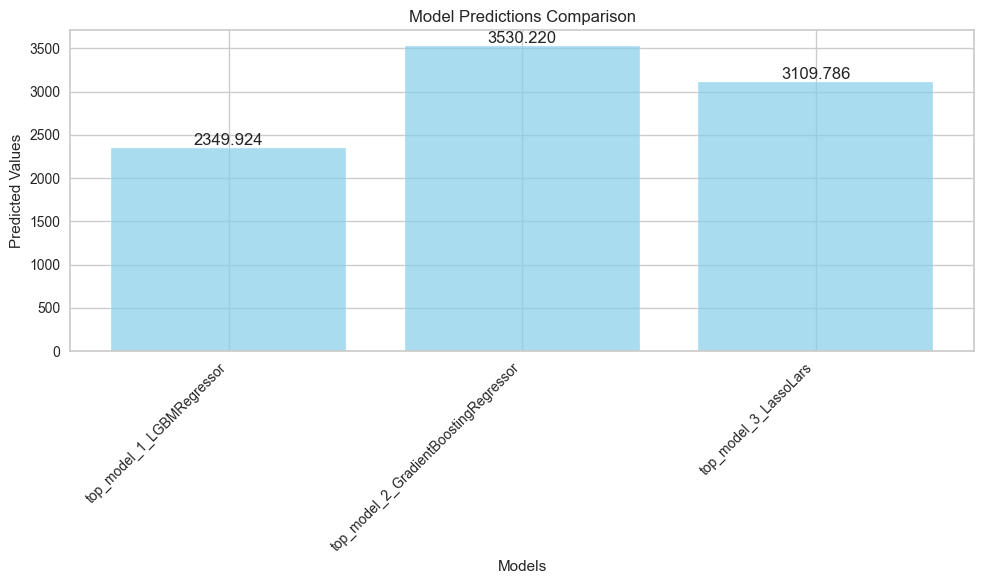


📝 Copy the cell examples above to get started quickly in your Jupyter notebook!
🎉 Setup complete! Happy predicting!

Making predictions with 3 models...
✗ top_model_1_LGBMRegressor: Error - name 'features_dict' is not defined
✗ top_model_2_GradientBoostingRegressor: Error - name 'features_dict' is not defined
✗ top_model_3_LassoLars: Error - name 'features_dict' is not defined
predictions are: {'top_model_1_LGBMRegressor': None, 'top_model_2_GradientBoostingRegressor': None, 'top_model_3_LassoLars': None}
Cell executed at: 2025-07-08 11:43:15.177017


In [16]:
# =============================================================================
# NOTEBOOK CELL EXECUTION HELPERS
# =============================================================================

# For easy copy-paste into notebook cells:


# CELL 1: Setup and Check Environment
setup_notebook_environment()

# CELL 2: Quick Start Guide
quick_start_guide()

loaded_models = load_all_models()
model_names = [name for name in loaded_models.keys() if name != 'standard_scaler']

# CELL 3: Single Prediction Demo
predictions = demo_single_prediction()

# CELL 4: Run Complete Analysis (if models are available)
#results = run_complete_analysis()


# CELL 5: Interactive Prediction Interface
#create_interactive_prediction_interface()

# CELL 6: Process your own CSV file
# results_df = process_csv_file('path/to/your/data.csv')

# CELL 7: What-If Analysis
#what_if_results = demo_what_if_analysis()

# CELL 8: Feature Importance Analysis
#importance_results = demo_feature_importance()


print("\n📝 Copy the cell examples above to get started quickly in your Jupyter notebook!")
print("🎉 Setup complete! Happy predicting!")



print(f"\nMaking predictions with {len(model_names)} models...")

predictions = {}

for model_name in model_names:
    try:
        prediction = predict_with_single_model(
            features_dict, model_name, loaded_models, use_scaler
        )

        if prediction is not None:
            predictions[model_name] = prediction
            print(f"✓ {model_name}: {prediction:.3f}")
        else:
            print(f"✗ {model_name}: Prediction failed")
            predictions[model_name] = None

    except Exception as e:
        print(f"✗ {model_name}: Error - {str(e)}")
        predictions[model_name] = None

print(f"predictions are: {predictions}")


In [ ]:
# =============================================================================
# FEATURE IMPORTANCE AND ANALYSIS
# =============================================================================

def get_feature_importance(model_name: str, loaded_models: Dict) -> Optional[np.ndarray]:
    """
    Get feature importance for a given model if available.
    
    Args:
        model_name (str): Name of the model to analyze
        loaded_models (Dict): Dictionary of loaded models
        
    Returns:
        Optional[np.ndarray]: Feature importance values or None if not available
    """
    if model_name not in loaded_models:
        logging.error(f"Model '{model_name}' not found in loaded models")
        return None
    
    model = loaded_models[model_name]['model']
    
    try:
        # For PyCaret models, try to access the underlying estimator
        if hasattr(model, 'named_steps'):
            # Pipeline case
            estimator = None
            for step_name, step in model.named_steps.items():
                if hasattr(step, 'feature_importances_') or hasattr(step, 'coef_'):
                    estimator = step
                    break
        elif hasattr(model, '_final_estimator'):
            estimator = model._final_estimator
        else:
            estimator = model
        
        # Check for feature importances
        if hasattr(estimator, 'feature_importances_'):
            importances = estimator.feature_importances_
            logging.info(f"Retrieved feature importance from '{model_name}' (feature_importances_)")
            return importances
        
        # For linear models, use coefficients
        elif hasattr(estimator, 'coef_'):
            importances = np.abs(estimator.coef_)
            if importances.ndim > 1:
                importances = importances.flatten()
            logging.info(f"Retrieved feature importance from '{model_name}' (coefficients)")
            return importances
        
        logging.warning(f"Model '{model_name}' does not support feature importance")
        return None
        
    except Exception as e:
        logging.error(f"Error getting feature importance for '{model_name}': {str(e)}")
        return None

def analyze_feature_importance_all_models(loaded_models: Dict) -> Dict[str, np.ndarray]:
    """
    Get feature importance for all models that support it.
    
    Args:
        loaded_models (Dict): Dictionary of loaded models
        
    Returns:
        Dict[str, np.ndarray]: Dictionary with model names and feature importances
    """
    importance_results = {}
    model_names = [name for name in loaded_models.keys() if name != SCALER_FILE]
    
    print("\nAnalyzing feature importance for all models...")
    
    for model_name in model_names:
        importance = get_feature_importance(model_name, loaded_models)
        if importance is not None:
            importance_results[model_name] = importance
            print(f"✓ {model_name}: Feature importance extracted")
        else:
            print(f"✗ {model_name}: No feature importance available")
    
    return importance_results



In [ ]:
# =============================================================================
# WHAT-IF ANALYSIS
# =============================================================================

def analyze_what_if(
    base_features_dict: dict,
    model_name: str,
    loaded_models: Dict,
    param_name: str,
    param_values: List[float],
    use_scaler: bool = True
) -> Dict[str, List]:
    """
    Perform what-if analysis by varying one parameter and observing predictions.
    
    Args:
        base_features_dict (dict): Base feature values as dictionary
        model_name (str): Name of the model to use
        loaded_models (Dict): Dictionary of loaded models
        param_name (str): Name of the parameter to vary
        param_values (List[float]): Values to use for the parameter
        use_scaler (bool): Whether to apply scaling if available
        
    Returns:
        Dict[str, List]: Dictionary with parameter values and predictions
    """
    results = {
        "param_values": [],
        "predictions": []
    }
    
    print(f"\nPerforming what-if analysis for '{param_name}' with model '{model_name}'...")
    
    for value in param_values:
        try:
            # Create a copy of features and modify the specified parameter
            modified_features = base_features_dict.copy()
            modified_features[param_name] = value
            
            # Make prediction
            prediction = predict_with_single_model(
                modified_features, model_name, loaded_models, use_scaler
            )
            
            if prediction is not None:
                results["param_values"].append(value)
                results["predictions"].append(prediction)
            
        except Exception as e:
            logging.error(f"Error in what-if analysis for value {value}: {str(e)}")
    
    print(f"What-if analysis completed: {len(results['predictions'])} data points")
    return results

